In [1]:
# For extracting the eigenvalue from the ground state estimate, we will use 
# Quantum Phase Estimation, sampled over a data set with different time steps.

In [43]:
import sys

sys.path.append("../../src/groundstate_prep")
from ground_state_prep import prepare_ground_state
from utils_gsp import approx_polynomial, get_phis, U

sys.path.append("../../src/groundstate_prep")
from ground_state_prep_qiskit import qetu_rqc_oneLayer

sys.path.append("../../src/lindbladian")
from lindbladian import ideal_lindbladian, circuit_implementation_lindbladian
from utils_lind import crandn

sys.path.append("../../src/rqcopt")
from optimize import ising1d_dynamics_opt

sys.path.append("../../src/qpe")
from qpe import estimate_phases, qc_estimate_phases

In [44]:
# Hamiltonian.

import numpy as np
from numpy import linalg as LA
import qib
import matplotlib.pyplot as plt

# Parameters for the Ising Hamiltonian
# L has to be even! Due to K only being able to control even Ls!
L, J, h, g = (6, 1, 0, 1)


# construct Hamiltonian
latt = qib.lattice.IntegerLattice((L,), pbc=True)
field = qib.field.Field(qib.field.ParticleType.QUBIT, latt)
hamil = qib.IsingHamiltonian(field, J, h, g).as_matrix().toarray()

eigenvalues, eigenvectors = LA.eig(hamil)
idx = eigenvalues.argsort()
eigenvalues_sort = eigenvalues[idx]
eigenvectors_sort = eigenvectors[:,idx]
ground_state = eigenvectors_sort[:, 0]
print("Ground State Energy", eigenvalues_sort[0].real)

Ground State Energy -7.72740661031253


In [45]:
# Linear transformation of the hamiltonian to fit the eigenvalues in the [-1, 1] interval.

dist = 0.001

# Have to be guessed, depending on the used Hamiltonian
# If we have a good initial overlap, we can decrease this 
# max_spectrum_length and get a larger spectral gap after transformation.
max_spectrum_length = 16
ground_energy_lower_bound = -12
c1 = (np.pi-2*dist) / (max_spectrum_length)
c2 = dist - c1 * ground_energy_lower_bound

eigenvalues_tr = eigenvalues_sort * c1 + c2
a_values = np.array([np.cos(eig/2) for eig in eigenvalues_tr])

print("a_max", a_values[0])
print("a_premax", a_values[1])
print("c1: ", c1)
print("c2: ", c2)
print("t: ", 0.5*c1)

a_max (0.913213738245949-0j)
a_premax (0.902383564242937-0j)
c1:  0.19622454084936208
c2:  2.3556944901923447
t:  0.09811227042468104


Absolute Error for the Eigenvalue:  0.5830838054621958


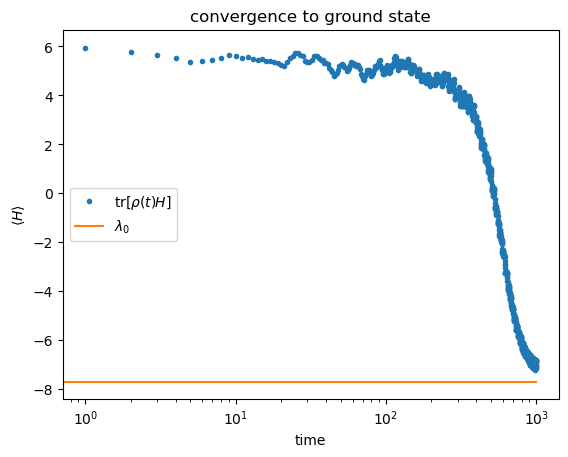


Layer 0
Prob 0: 0.08960735544934423
Prob 1: 0.910392644550674

Layer 1
Prob 0: 0.1108781178264271
Prob 1: 0.8891218821735904

Layer 2
Prob 0: 0.11449658835964048
Prob 1: 0.8855034116403755

Layer 3
Prob 0: 0.11545161975949242
Prob 1: 0.8845483802405235

Layer 4
Prob 0: 0.1157150851604257
Prob 1: 0.8842849148395888

F(a_max) = (0.11583628418758912+0j)

 ---------- 
 SUCCESS! 

Fidelity of the initial state to the ground state: 0.7291029018103746
Fidelity of the prepared state to the ground state: 0.9996679448861971


In [46]:
# Here we use Lindbladian + QETU to prepare the ground state.

mu, d, c, phis_max_iter, = (0.92, 30, 0.95, 10)

tau, nsteps = (1,1000)
end_state_lind, en_list, err = circuit_implementation_lindbladian(hamil, L, tau=tau, nsteps=nsteps)

print("Absolute Error for the Eigenvalue: ", err)
plt.semilogx(tau * np.arange(nsteps + 1), en_list, ".", label=r"$\mathrm{tr}[\rho(t) H]$")
plt.semilogx(tau * np.arange(nsteps + 1), (eigenvalues_sort[0]*np.ones(nsteps + 1)).real, label=r"$\lambda_0$")
plt.legend()
plt.xlabel("time")
plt.ylabel(r"$\langle H \rangle$")
plt.title("convergence to ground state")
plt.show()


ket_0 = np.array([1,0])

end_state_qetu, E = prepare_ground_state(
                        np.kron(ket_0, end_state_lind), mu, d, c, phis_max_iter,
                        np.kron(np.array([1, 0]), ground_state), L, J, g, eigenvalues_sort[0],
                        hamil=hamil, max_reps=5, tau=c1, shift=c2, a_max=a_values[0]
)

In [ ]:
# Demonstrate dataset creation for QCELS Fitting with Blanes-Moan Splitting.

import rqcopt as oc
coeffs = oc.SplittingMethod.blanes_moan().coeffs
phase_estimates, phase_exacts = estimate_phases(L, J, g, end_state_qetu, eigenvalues_sort, 
                                                tau=0.01, N=100, shots=1e5, 
                                                depolarizing_error=0, rqc=False, 
                                                coeffs=coeffs, )

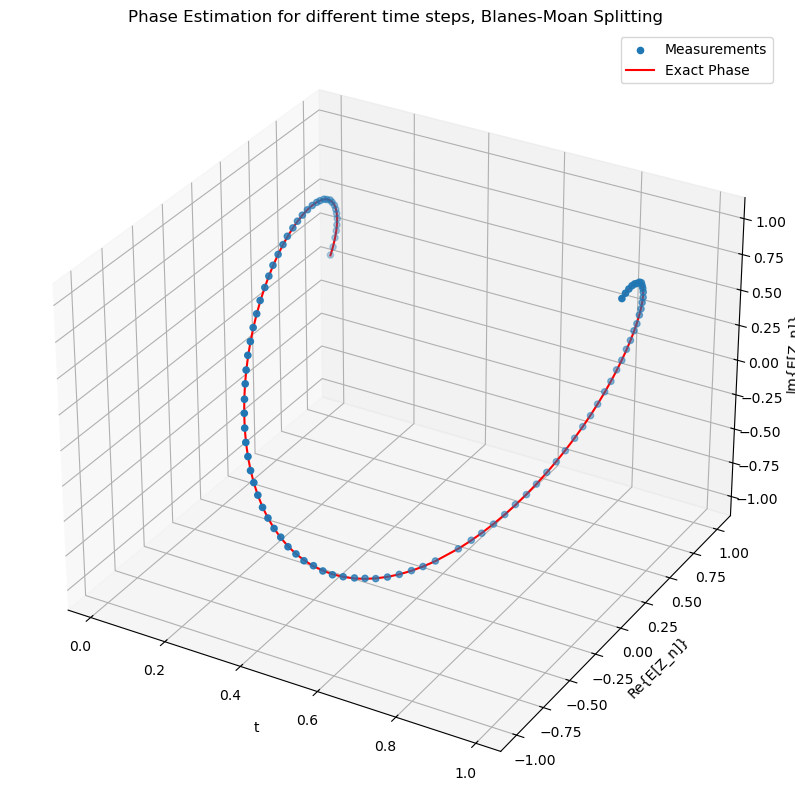

In [28]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

phase_estimates = np.array(phase_estimates)
phase_exacts = np.array(phase_exacts)
ax.scatter(phase_estimates[:, 0], phase_estimates[:, 1].real, phase_estimates[:, 1].imag, label="Measurements")
ax.plot(phase_exacts[:,0], phase_exacts[:,1].real, phase_exacts[:,1].imag, label="Exact Phase", color="red")
plt.title("Phase Estimation for different time steps, Blanes-Moan Splitting")
plt.xlabel("t")
plt.ylabel("Re{E[Z_n]}")
ax.set_zlabel("Im{E[Z_n]}")
ax.legend()

In [29]:
# Fitting of the gathered dataset to an exponential function.

def f(theta, phase_estimates):
    total_sum = 0
    for i, t in enumerate(phase_estimates[:, 0]):
        Zn = phase_estimates[:, 1][i]
        total_sum += Zn * np.exp(1j*t*theta)
    return np.linalg.norm(total_sum)**2

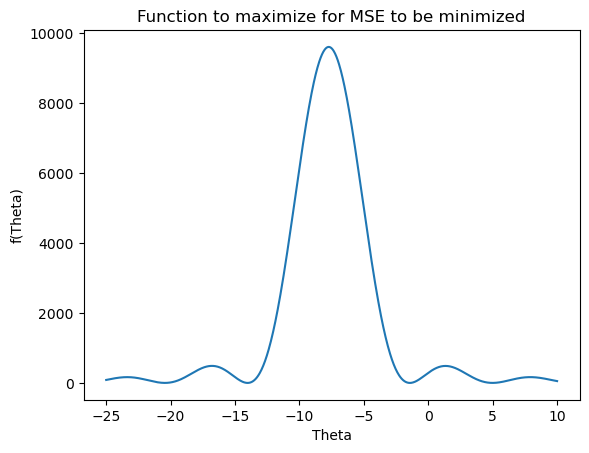

In [30]:
theta_values = np.linspace(-25, 10, 1000)
f_values = [f(theta, phase_estimates) for theta in theta_values]
plt.title("Function to maximize for MSE to be minimized")
plt.xlabel("Theta")
plt.ylabel("f(Theta)")
plt.plot(theta_values, f_values)
plt.show()

In [31]:
import scipy

theta0 = scipy.optimize.fmin(lambda theta: -f(theta, phase_estimates), -7)
print("Absolute Error: ", np.linalg.norm(theta0 - eigenvalues_sort[0]))

Optimization terminated successfully.
         Current function value: -9602.641028
         Iterations: 14
         Function evaluations: 28
Absolute Error:  0.001088250937527846


In [ ]:
# Demonstrate dataset creation for QCELS Fitting with RQCOpt.

phase_estimates, phase_exacts = estimate_phases(L, J, g, end_state_qetu, eigenvalues_sort, 
                                                tau=0.01, N=100, shots=1e5, 
                                                depolarizing_error=0, rqc=True)

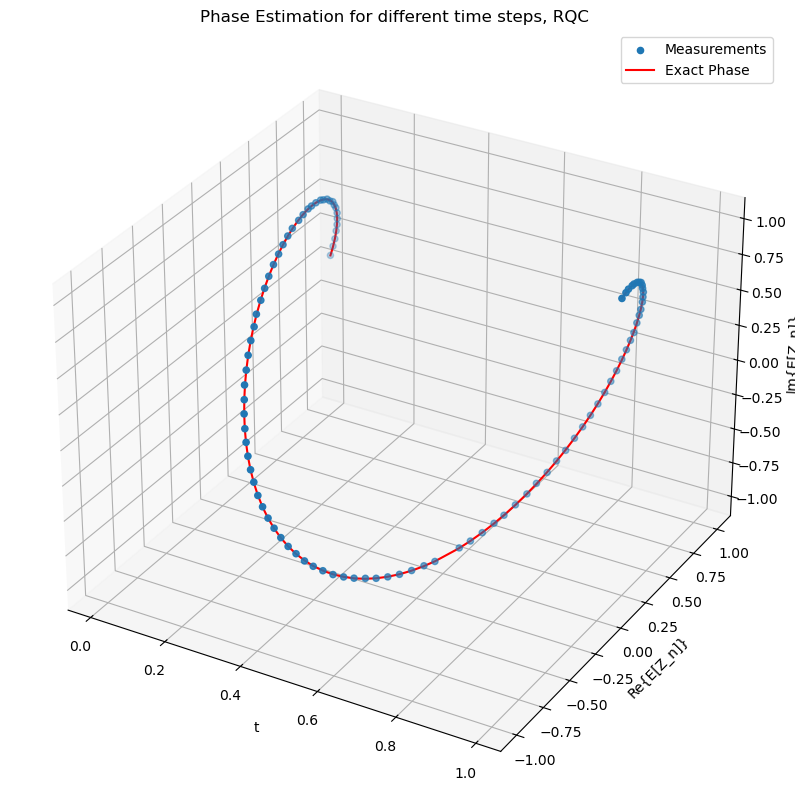

In [33]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

phase_estimates = np.array(phase_estimates)
phase_exacts = np.array(phase_exacts)
ax.scatter(phase_estimates[:, 0], phase_estimates[:, 1].real, phase_estimates[:, 1].imag, label="Measurements")
ax.plot(phase_exacts[:,0], phase_exacts[:,1].real, phase_exacts[:,1].imag, label="Exact Phase", color="red")
plt.title("Phase Estimation for different time steps, RQC")
plt.xlabel("t")
plt.ylabel("Re{E[Z_n]}")
ax.set_zlabel("Im{E[Z_n]}")
ax.legend()

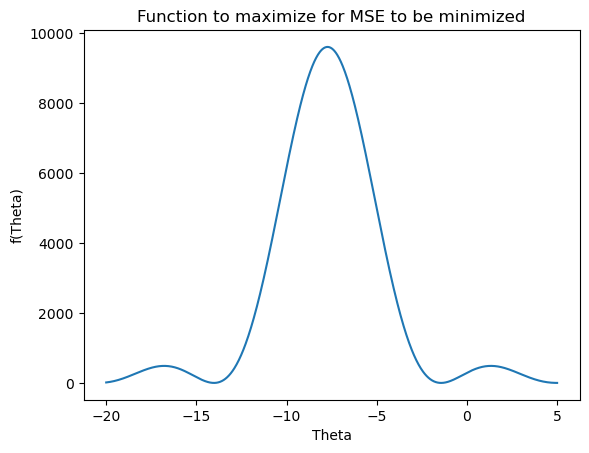

Optimization terminated successfully.
         Current function value: -9603.286570
         Iterations: 14
         Function evaluations: 28
Absolute Error:  0.00019348734372215404


In [34]:
import scipy

def f(theta, phase_estimates):
    total_sum = 0
    for i, t in enumerate(phase_estimates[:, 0]):
        Zn = phase_estimates[:, 1][i]
        total_sum += Zn * np.exp(1j*t*theta)
    return np.linalg.norm(total_sum)**2


theta_values = np.linspace(-20, 5, 1000)
f_values = [f(theta, phase_estimates) for theta in theta_values]
plt.title("Function to maximize for MSE to be minimized")
plt.xlabel("Theta")
plt.ylabel("f(Theta)")
plt.plot(theta_values, f_values)
plt.show()

theta0 = scipy.optimize.fmin(lambda theta: -f(theta, phase_estimates), -7)
print("Absolute Error: ", np.linalg.norm(theta0 - eigenvalues_sort[0]))

In [ ]:
# Demonstrate dataset creation for QCELS Fitting with different 
# time evolution operators and noise 

import rqcopt as oc
coeffs = oc.SplittingMethod.blanes_moan().coeffs
phase_estimates, phase_exacts = estimate_phases(L, J, g, end_state_qetu, eigenvalues_sort, 
                                                tau=0.01, N=25, shots=1e5, 
                                                depolarizing_error=1e-4, rqc=False, 
                                                coeffs=coeffs)

In [8]:
mu = 0.92

qc_qetu_RQC = qetu_rqc_oneLayer(
                       L, J, g, c1/2, mu, a_values, c2
)

Running decomposition of two-qubit gates of the RQC Circuit...
F(a_max)^2:  (0.11583628418758912+0j)


In [ ]:
phase_estimates, phase_exacts = qc_estimate_phases(L, J, g, qc_qetu_RQC, eigenvalues_sort, 
                                                tau=0.01, N=25, shots=1e4,
                                                depolarizing_error=1e-4, rqc=True, qetu_repeat=3)

In [15]:
import scipy

phase_estimates = np.array(phase_estimates)
theta0 = scipy.optimize.fmin(lambda theta: -f(theta, phase_estimates), -7)
print(f"RQC, Depolar. Noise: 1e-4 ,Absolute Error: ", np.linalg.norm(theta0 - eigenvalues_sort[0]))

Optimization terminated successfully.
         Current function value: -521.273571
         Iterations: 14
         Function evaluations: 28
RQC, Depolar. Noise: 1e-4 ,Absolute Error:  0.07713805562502785


In [ ]:
phase_estimates, phase_exacts = qc_estimate_phases(L, J, g, qc_qetu_RQC, eigenvalues_sort, 
                                                tau=0.01, N=25, shots=1e4,
                                                depolarizing_error=1e-4, rqc=False, coeffs=coeffs)

In [20]:
import scipy

phase_estimates = np.array(phase_estimates)
theta0 = scipy.optimize.fmin(lambda theta: -f(theta, phase_estimates), -7)
print(f"Blanes-Moan, Depolar. Noise: 1e-4 ,Absolute Error: ", np.linalg.norm(theta0 - eigenvalues_sort[0]))

Optimization terminated successfully.
         Current function value: -461.464778
         Iterations: 14
         Function evaluations: 28
Blanes-Moan, Depolar. Noise: 1e-4 ,Absolute Error:  0.046205438437528557


In [36]:
phase_estimates, phase_exacts = estimate_phases(L, J, g, end_state_qetu, eigenvalues_sort, 
                                                tau=0.01, N=100, shots=1e5, 
                                                depolarizing_error=0, rqc=True)

In [37]:
import scipy

def f(theta, phase_estimates):
    total_sum = 0
    for i, t in enumerate(phase_estimates[:, 0]):
        Zn = phase_estimates[:, 1][i]
        total_sum += Zn * np.exp(1j*t*theta)
    return np.linalg.norm(total_sum)**2

phase_estimates = np.array(phase_estimates)
theta0 = scipy.optimize.fmin(lambda theta: -f(theta, phase_estimates), -7)
print(f"RQC, Depolar. Noise: 0 , tau=1e-2, n=1e2, shots=1e5, Absolute Error: ", np.linalg.norm(theta0 - eigenvalues_sort[0]))

Optimization terminated successfully.
         Current function value: -9606.072487
         Iterations: 14
         Function evaluations: 28
RQC, Depolar. Noise: 0 , tau=1e-2, n=1e2, shots=1e5, Absolute Error:  0.0015606748437217988


In [41]:
import rqcopt as oc
coeffs = oc.SplittingMethod.blanes_moan().coeffs

phase_estimates, phase_exacts = estimate_phases(L, J, g, end_state_qetu, eigenvalues_sort, 
                                                tau=0.01, N=20, shots=1e5,
                                                depolarizing_error=0, rqc=False, coeffs=coeffs)

In [42]:
import scipy

def f(theta, phase_estimates):
    total_sum = 0
    for i, t in enumerate(phase_estimates[:, 0]):
        Zn = phase_estimates[:, 1][i]
        total_sum += Zn * np.exp(1j*t*theta)
    return np.linalg.norm(total_sum)**2

phase_estimates = np.array(phase_estimates)
theta0 = scipy.optimize.fmin(lambda theta: -f(theta, phase_estimates), -7)
print(f"Blanes-Moan, Depolar. Noise: 0 , tau=1e-2, n=1e3, shots=1e5, Absolute Error: ", np.linalg.norm(theta0 - eigenvalues_sort[0]))

Optimization terminated successfully.
         Current function value: -361.221975
         Iterations: 14
         Function evaluations: 28
Blanes-Moan, Depolar. Noise: 0 , tau=1e-2, n=1e3, shots=1e5, Absolute Error:  0.017881475624970555


In [24]:
coeffs = oc.SplittingMethod.suzuki(2, 1).coeffs

phase_estimates, phase_exacts = estimate_phases(L, J, g, end_state_qetu, eigenvalues_sort, 
                                                tau=0.01, N=100, shots=1e5, 
                                                depolarizing_error=0, rqc=False, coeffs=coeffs)

In [26]:
phase_estimates = np.array(phase_estimates)
theta0 = scipy.optimize.fmin(lambda theta: -f(theta, phase_estimates), -7)
print(f"1st Order, Strang-3, Depolar. Noise: 0 , tau=1e-2, n=1e2, shots=1e5, Absolute Error: ", np.linalg.norm(theta0 - eigenvalues_sort[0]))

Optimization terminated successfully.
         Current function value: -9071.278253
         Iterations: 14
         Function evaluations: 28
1st Order, Strang-3, Depolar. Noise: 0 , tau=1e-2, n=1e2, shots=1e5, Absolute Error:  0.18403502828127927
